In [29]:
import geopandas as gpd
import pandas as pd
import math
import json
import numpy as np
from sqlalchemy import create_engine
import bisect
# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


In [30]:
# TODO: model some electicity price curve that (randomly) changes over the day
#electricity_price = np.ones(EPISODE_LEN)
electricity_price = np.zeros(96)
electricity_price[:24] = 0.2
electricity_price[24:40] = 0.25
electricity_price[40:44] = 0.22
electricity_price[44:56] = 0.2
electricity_price[56:68] = 0.22
electricity_price[68:84] = 0.25
electricity_price[84:] = 0.22

### todo: check beginning of day, service reservations

In [34]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from rl_v2g.plotting import show_soc, my_cmap

class CarsharingEnv(gym.Env):
    def __init__(self, stations, vehicle_information, episode_len = 24, dt=0.25, cancellation_penalty = 100, penalty_per_kwh = 0.25, v2g = True, v2g_demand_event = 500, V2G_penalty = 10000, planned_bookings = True, max_distance_car_assingment = 5000):
        """
        Parameters
        ----------
        stations: Geopandas Geodataframe
            Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.
        vehicle_information: Pandas Dataframe
            Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.
        episode_len: int, optional
            Length of one episode in hours, by default 24.
        dt: float, optional
            Time step size in hours, by default 0.25 (a quarter hour).
        cancellation_penalty: int, optional
            Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.
        penalty_per_kwh: int, optional
            Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.
        v2g: boolean, optional
            Boolean indicating if V2G events take place, by default True.
        v2g_demand_event: int, optional
            Energy demand during V2G event in kWh per time step (dt), by default 500.
        V2G_penalty: int, optional
            Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.
        planned_bookings: boolean, optional
            Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.
        max_distance_car_assingment: int, optional
            Maximum search distance in meter for Car-assingment problem, by default 5000.
        ----------
        Observation space: 5 parts:
        1) Location for each car (three options):
            - Station number (1000-5000)
            - Reservation number (2x'xxx'xxx) during trip
            - Reservation number (3x'xxx'xxx) during relocation
            - -1 if car is not available
        2) State of charge (SOC) for each vehicle (between 0 and 1).
        3) Timestamp of the next planned booking for each car (discrete between 0 and self.episode_len).
        4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
        5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
        Remark: States 3) and 4) are only included if the variable "planned_bookings" is True.
        ----------
        Action space: 3 actions for each car:
        1) 0 = do nothing.
        2) 1 = charging.
        3) 3 = discharging (V2G).
        """
        # environment settings
        self.dt = dt
        self.episode_len = int(episode_len / self.dt) 
        self.planned_bookings = planned_bookings
        self.max_distance_car_assingment = max_distance_car_assingment
    
        # stations in system
        self.stations = stations
        
        # vehicle information
        self.vehicles_id = vehicle_information["vehicle_no"]
        self.nr_vehicles = len(self.vehicles_id)
        self.chariging_power = vehicle_information["charge_power"]
        self.battery_capacities = vehicle_information["battery_capacity"] 
        self.vehicle_type = vehicle_information["vehicle_category"] 
        
        # V2G Demand
        self.v2g_demand = v2g_demand_event
        
        # penalties
        self.cancellation_penalty = cancellation_penalty
        self.penalty_per_kwh = penalty_per_kwh
        self.v2g_penalty = V2G_penalty
        
        # define observation space:
        if self.planned_bookings is True:
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0, -1, -1] * self.nr_vehicles),
                    high=np.array([9999999, 1, 96, 100] * self.nr_vehicles),
                ),
                'v2g_event_feature': gym.spaces.Discrete(2)
            })
        else: 
            self.observation_space = gym.spaces.Dict({
                'car_features': gym.spaces.Box(
                    low=np.array([-1, 0] * self.nr_vehicles),
                    high=np.array([9999999, 1] * self.nr_vehicles)
                ),
                'v2g_event_feature': gym.spaces.Discrete(2)
            })
        
    
        # action space
        self.action_space = spaces.MultiDiscrete([3 for _ in range(self.nr_vehicles)])
        
        
        sql = "SELECT reservation_no FROM mobility.service_reservation"
        test = pd.read_sql(sql, engine)
        self.test = test
        
    def reset(self, daily_data, reservations):
        """
        Parameters
        ----------
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        self.state: numpy ndarray
            The reset state of the environment at the first time step. It includes the following information for each car:
            1) Location:
                - Station number (1000-5000)
                - Reservation number (2x'xxx'xxx) during trip
                - Reservation number (3x'xxx'xxx) during relocation
                - -1 if the car is not available
            2) State of charge (SOC) for each vehicle (between 0 and 1).
            3) Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
            4) Duration of the next planned booking (measured in the number of time steps of length self.dt).
            5) Binary variable indicating the occurrence of a vehicle-to-grid (V2G) event.
            Note: The information in 3) and 4) is included only if the variable "planned_bookings" is True.
        """
        
        # set time to 0
        self.t = 0
        
        # reset reward lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list = []
        
        # reset state
        self.state_old = np.zeros(self.nr_vehicles * 4 + 1)
        
        # reset planned reservations:
        self.planned_reservations_car = {key: [] for key in self.vehicles_id}
        
        
        ### initialize state at t = 0 ###
        
        # 1) car locations (three options)
        car_locations = daily_data.iloc[:,0].values
        
        # 2) SOC (state of charge) ##
        car_SOC = np.random.rand(self.nr_vehicles) # random values between 0-100%
        #car_SOC = np.zeros(self.nr_vehicles) # all car batteries empty (0%)
        #car_SOC = np.full((self.nr_vehicles,), 0.2) # all car batteries at 20%
        #car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles) # All cars randomly between 50-100%
        #np.random.seed(42)
        #rng = np.random.RandomState(42)
        #car_SOC = rng.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
         # state 5) Binary V2G event
        v2g_event = np.array([0])
 
        # final state with planned bookings
        if self.planned_bookings is True:
            # 3) timestamp of next planned reservation 
            # 4) Duration of next planned reservation
            next_reservation, duration_next_reservation = self.update_reservation_state(reservations, True)
            
            # concatinate states 1-5
            self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation, v2g_event])
        else:
            self.state = np.concatenate([car_locations, car_SOC, v2g_event])
        
        # save energy at beginning of episode (relevant for reward)
        self.energy_beginning = sum(car_SOC * self.battery_capacities)

        return self.state
    
    def update_reservation_state(self, reservations, reset):
        """
         Parameters
        ----------
        reservations: Pandas DataFrame
            Includes the features "syscreatedate_daytime", "vehicle_no", "reservationfrom_daytime", and "reservation_duration" for each reservation.
        reset: boolean, optional
            Boolean indicating whether to reset the environment or not.
            
        Returns
        ----------
        next_reservation : numpy ndarray
            Timestamp of the next planned booking for each car (discrete value between 0 and self.episode_len).
        duration_next_reservation : numpy ndarray
            Duration of the next planned booking (measured in the number of time steps of length self.dt).
        """

        # initalize variables if during reset of environment
        if reset is True:
            time = 0
            next_reservation = np.ones(self.nr_vehicles) * -1
            duration_next_reservation = np.ones(self.nr_vehicles) * -1
            
        # get current state of next planned reservations (timestamp and duration)
        else:
            time = self.t + 1
            next_reservation = self.state[self.nr_vehicles * 2 :self.nr_vehicles *3]
            duration_next_reservation = self.state[self.nr_vehicles * 3 :self.nr_vehicles * 4]
            
        # filter reservations: 
        # bookings before t = 0 have value syscreatedate_daytime = 0
        reservations_t =  reservations[reservations["syscreatedate_daytime"] == time]
        

        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of car
            current_car = reservations_t[reservations_t["vehicle_no"] == vehicle_id]


            # remove reservations in past
            if len(self.planned_reservations_car[vehicle_id]) != 0:
                if int(self.planned_reservations_car[vehicle_id][0][0]) < self.t:
                    self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

            # skip if no new reservation found
            if len(current_car) == 0:
                
                # if current state's reservation is in the past 
                if next_reservation[count] <  self.t and next_reservation[count] != -1:
                    
                    # check for planned reservations saved in the past
                    if len(self.planned_reservations_car[vehicle_id]) != 0:
                        # save reservation timestamp
                        next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                        # save reservation duration
                        duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                        # remove reservation from dict with planned reservations
                        self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]

                    else:
                        # assign -1 for no planned reservation
                        next_reservation[count] = -1
                        duration_next_reservation[count] = -1
                count +=1

                continue

            for i in range(0,len(current_car)):    
                
                # get timestamp and duration of next planned reservation
                reservation_time = current_car["reservationfrom_daytime"].iloc[i]
                reservation_duration = current_car["reservation_duration"].iloc[i]
                
                # save directly if during reset of environment
                if i == 0 and reset is True:
                    # save timestamp of next reservation
                    next_reservation[count] = reservation_time

                    # save reservation duration
                    duration_next_reservation[count] = reservation_duration


                if reset is True:
                    # save directly first reseration during reset of environment
                    if i == 0 and reset is True:
                        # save timestamp of next reservation
                        next_reservation[count] = reservation_time

                        # save reservation duration
                        duration_next_reservation[count] = reservation_duration
                    
                    # save other found reservation during reset of environment in dict
                    else:
                        new_reservation = [reservation_time, reservation_duration]

                        # remain order in dict (nearest reservation in first index)
                        index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])

                        # save timestamp and duration of new but later reservations in dict
                        self.planned_reservations_car[vehicle_id].insert(index, new_reservation)
                
                else: 
                    # save found reservation environment in dict
                    new_reservation = [reservation_time, reservation_duration]
                    
                    # remain order in dict (nearest reservation in first index)
                    index = bisect.bisect_left([sublist[0] for sublist in  self.planned_reservations_car[vehicle_id]], new_reservation[0])
                    
                    # save timestamp and duration of new but later reservations in dict
                    self.planned_reservations_car[vehicle_id].insert(index, new_reservation)

            # update only if reservation is before last planned reservation
            if  reset is False and self.planned_reservations_car[vehicle_id][0][0] <  next_reservation[count]:
                # save timestamp of next reservation
                next_reservation[count] = self.planned_reservations_car[vehicle_id][0][0]

                # save reservation duration
                duration_next_reservation[count] = self.planned_reservations_car[vehicle_id][0][1]

                # remove reservation from dict
                self.planned_reservations_car[vehicle_id] = self.planned_reservations_car[vehicle_id][1:]
                
            count += 1
        
        return next_reservation, duration_next_reservation
    
    def cancel_trips_low_SOC(self, daily_data, reservations):
        """
        Parameters
        ----------
       daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".

        Returns
        ----------
        penalty_counter: int
            Total factor of penalty for timestep.
        """

        # check if car booked or not (start of booking)
        on_trip = self.state[:self.nr_vehicles] > 1000000
        trip_start = self.state[:self.nr_vehicles] != self.state_old[:self.nr_vehicles]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()

        
        ### check if engough energy charged for booked trip (otherwise trips needs to be cancelled) ###
        
        # array with 0 for all car that do not start a new trip, otherwise 1
        soc_needed = np.zeros(len(result))
        
        # iterate over indices of cars that start a trip
        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                # todo: implement relocations
                pass
            else:
                try:
                    # calculate needed SOC for trip
                    soc_needed[trip_start] = reservations[reservations["reservation_no"] == reservation_no]["required_soc"].iloc[0] / 100
 
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
            
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.nr_vehicles:2*self.nr_vehicles] - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.nr_vehicles:2*self.nr_vehicles] = (self.state[self.nr_vehicles:2*self.nr_vehicles] - soc_needed * not_cancelled_trips_int) 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        # count number of cancellation, used for reward penalty
        penalty_counter = 0
 

        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            t = self.t
            
            # defualt car location if last location not found
            car_location = -1
            
            while not found:
                # search last station of car in bookings, replace reservation number with last location
                if t > 0:
                    car_location = daily_data.iloc[index, t]
                    if car_location >= 1000 and car_location <= 6000:
                        found = True
                        
                        # assign cancelled reservation to other avaiable car if possible, get cancellation penalty
                        penalty_counter += self.car_assignment(car_location, daily_data, reservations, index, soc_needed)
                else:
                    # if no station found back in time, stop loop
                    found = True
                t = t - 1
                
            # update current state of car with actual location
            self.state[:self.nr_vehicles][index] = car_location
            
            # remove reservation from dataset
            changed = False

            # iterate over row in discrete table of given car
            for col_index, col_data in enumerate(daily_data.iloc[index]):

                
                # remove reservation, replace reservation number by car location
                if col_index >= self.t + 1 and daily_data.iloc[index, col_index] >= 1000000:
                    daily_data.iat[index, col_index] = car_location
                    changed = True
                
                # stop loop if reservation cancelled
                elif col_index >= self.t and daily_data.iloc[index, col_index] < 1000000 and changed == True:
                    break
        
        # return total cancellation penalty
        return penalty_counter
    
    def car_assignment(self, station_id, daily_data, reservations, index_car, soc_needed):
        """
        Parameters
        ----------
        station_id: int
            ID of station with the cancelled reservation.
        daily_data: Pandas DataFrame
            Contains the car trips over the day.
        reservations: Pandas DataFrame
            Contains information about the cars, including "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category".
        index_car: int
            Index of the car with the cancelled reservaton
        soc_needed: int
            Minimum needed SOC for cancelled trip.

        Returns
        ----------
        penalty_counter: int
            Penalty of single cancelled reservation
        """
        
        # create local copy of station table
        stations_processing = self.stations.copy()
        
        #################### todo: problem at 23:45 timestamp ####################################

        # look for cars at the same station as cancelled reservation
        filtered_df = daily_data.loc[daily_data.iloc[:, self.t + 1] == station_id]
        
        # get cancelled reservation
        # if end of day (00:00)
        reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservation_no"] == daily_data.iloc[index_car, self.t + 1])]
        
        # if no reservation found
        if len(reservations_of_car) == 0:
            print("")
            print("Reservation in Discrete table not found in Reservation table")
            print("Station ID")
            print(station_id)
            print("Car ID")
            print(self.vehicles_id[index_car])
            print("Reservation_number")
            print(daily_data.iloc[index_car, self.t + 1])
   
            
            # return zero penalty
            return 0
        
        # get cancelled reservation duration
        reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
        
        # get cancelled reservation number
        reservation_no = reservations_of_car["reservation_no"].iloc[0]
        
        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id]
        
        # car type of cancelled car
        car_type_cancelled = self.vehicle_type[index_car]
        
        # search available cars at stations in the neigbourhood of the cancelled reservation's car
        solution_found = False
        while solution_found is not True:
            # perform the nearest neighbor join for getting nearest distance
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = self.max_distance_car_assingment)
            
            # no station found within 5km distance
            if len(joined) == 0:
                solution_found = True
                
                # return maximum penalty
                penalty = 1
                break
                
            # get station ID of nearest found station
            alternative_station_ID = joined["station_no_right"].iloc[0]
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.nr_vehicles] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars
            for index in indices:
                
                # search for reservations during time period of cancelled reservation
                reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)] 
                    

                # if alternative car available (no reservation yet) and SOC high enough for trip
                if len(reservations_of_found_car) == 0 and (self.state[self.nr_vehicles:2*self.nr_vehicles][index] - soc_needed[index_car]) >= 0 and self.state[:self.nr_vehicles][index] >= 1000 and self.state[:self.nr_vehicles][index] <= 1000000 and car_type_cancelled == self.vehicle_type[index]:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    
                    # update discrete table of found car 
                    for col_index, col_data in enumerate(daily_data.iloc[index]):
                        
                        ############ overlapping if reservation only in discrete table? ############
                        
                        # add reservation to discrete table
                        if col_index > self.t + 1 and col_index <= self.t + 1 + reservation_duration:
                            daily_data.iat[index, col_index] = reservation_no                    
                    
                        # add SOC to discrete table
                        elif col_index == self.t + 1:
                            daily_data.iat[index, col_index] = reservation_no     

                            # remove used SOC during trip from vehicle state
                            self.state[self.nr_vehicles+ index] = (self.state[self.nr_vehicles + index] - soc_needed[index_car]) 
                        
                            # update state
                            self.state[index] = reservation_no
                            
                            
                        # end of reservation time period
                        elif col_index > self.t + 1 + reservation_duration:
                            break
                            
                    # stopp searching for alternative car if a solution is already found
                    break
                    
            # remove already checked station for next iteration
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                                
        # return penalty of cancellation
        return penalty
    
    def charging(self, action, not_chargable):
        
        ############ todo: implement charging function ############
    
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
        #energy_to_charge = charging_action * POWER_charge * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:2*self.nr_vehicles]

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        
        ############ todo: implement discharging function ############
        
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * self.chariging_power.tolist() * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:2*self.nr_vehicles]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    
    
    def update_SOC_charging(self, energy_to_charge):    
        self.state[self.nr_vehicles:2*self.nr_vehicles] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        # update SOC state
        self.state[self.nr_vehicles:2*self.nr_vehicles] += energy_to_discharge / self.battery_capacities
        
        return 
    

    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price):
        ############ todo ############ 
        ############ trip revenue from database ############
        ############ cancellation penalty distance weigthed (car assingment) ############
        ############ penalty for full charging or empty discharging ############
        skip = False
        # check if car on trip
        #on_trip = (self.state[:self.nr_vehicles] >= 0) & (
        #            self.state[:self.nr_vehicles] <= 100)
        #on_trip_indices = np.where(on_trip)[0].tolist()
        
        on_trip = self.state[:self.nr_vehicles] > 1000000
        trip_start = self.state[:self.nr_vehicles] != self.state_old[:self.nr_vehicles]
        result = on_trip & trip_start
        on_trip_indices = np.where(result)[0].tolist()
        
        sum_reward_trip = 0

        for trip_start in on_trip_indices:
            reservation_no = self.state[trip_start]
            if reservation_no >= 30000000:
                pass
            else:
                try:
                    duration_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_duration"].iloc[0]
                    distance_reward = reservations[reservations["reservation_no"] == reservation_no]["revenue_distance"].iloc[0]
                    total_reward_trip = duration_reward + distance_reward
                    sum_reward_trip += total_reward_trip 
                    
                    
                                
                    test = self.test[self.test["reservation_no"]==reservation_no]
                    if len(test) > 0:
                        print("xxxxxxxxxxxx Service Reservation xxxxxxxxxxxxxx")
                        print(self.t)
                        print(reservation_no)

                    
                    
                    if duration_reward is None:
                        print("")
                        print("duration null:")
                        print(reservation_no)
                    if distance_reward is None:
                        print("")
                        print("distance null:")
                        print(reservation_no)
                except Exception as E:
                    print("")
                    print(E)
                    print("reservation no")
                    print(reservation_no)
                    print(self.state[trip_start])
                    print("station_no")
                    print(self.state_old[trip_start])
                    print("vehicle id")
                    print(self.vehicles_id[trip_start])
                    


        ### compute reward ###
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t])
        
        # calculate discharging revenue
        rew_discharging = -np.sum(1 * energy_to_discharge * electricity_price[self.t])
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
                
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -self.cancellation_penalty * penalty_counter
        
        # penalty if not enough discharge for V2G
        if self.state[self.nr_vehicles *4:] == 1 and energy_to_discharge < v2g_demand_event:
            rew_discharging -= V2G_penalty
            
            pass
        
        # reward from cancelled reservations (0 distance)
        cancelled_revenue = reservations[(reservations["drive_km"] == 0) & (reservations["reservationfrom_daytime"] == self.t)]["revenue_duration"].sum()
        
        rew_energy_difference = 0
       
        difference_enery = sum(self.state[self.nr_vehicles:2*self.nr_vehicles] * self.battery_capacities) - self.energy_beginning
        difference_enery = min(difference_enery, 0)
        rew_energy_difference = difference_enery * self.penalty_per_kwh
        
        # total reward
        rew = rew_charging + rew_discharging + sum_reward_trip + reward_cancellations + rew_energy_difference + cancelled_revenue
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(sum_reward_trip)
        self.reward_list_charging.append(rew_charging)
        self.reward_list_discharging.append(rew_discharging)
        self.reward_list_cancellation_penalty.append(reward_cancellations)

        return rew
    

    def step(self, action, daily_data, reservations, electricity_price):
        ############ todo ############
        ############ include next trip in state ############ 
        self.state_old = self.state.copy()

        # cars cannot be returned from trips with negative loaded battery, set them zero
        #self.state[self.nr_vehicles:2*self.nr_vehicles][self.state[self.nr_vehicles:2*self.nr_vehicles] < 0] = 0
        
        #assert len(self.state[self.nr_vehicles:2*self.nr_vehicles][self.state[self.nr_vehicles:2*self.nr_vehicles] < 0]) == 0, "Vehicle SOC is wrong."
        print("minimum SOC")
        print(self.state[self.nr_vehicles:2*self.nr_vehicles].min())
        
        # get current car locations
        car_locations = daily_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.nr_vehicles] = car_locations
        
        # update state of reservations (timestamp and duration)
        next_reservation, duration_next_reservation = self.update_reservation_state(reservations, False)
        self.state[self.nr_vehicles * 2 :self.nr_vehicles *3] = next_reservation
        self.state[self.nr_vehicles * 3 :self.nr_vehicles * 4] = duration_next_reservation
        
        #print(self.planned_reservations_car)

        
        #self.update_state_next_reservations(last_timestamp, reservations, end_of_week)
       
        # cancel reservations if SOC to low for booked trip and update SOC
        penalty_counter = self.cancel_trips_low_SOC(daily_data, reservations)

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.nr_vehicles] < 1000) | (self.state[:self.nr_vehicles] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter, reservations, electricity_price)
        
        
        done = True if self.t == (self.episode_len - 2) else False
        # update time step
        self.t += 1

        return self.state, rew, daily_data, done, {}

    def render(self, daily_data):
        #print(f"-------- State at time {self.t} --------")
        print(f"-------- State at time {daily_data.columns[self.t]} --------")

        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        """timestamp = daily_data.columns[self.t]
        
        # plot location of vehicles
        on_trip = (self.state[:self.nr_vehicles] >= 1000000) | (self.state[:self.nr_vehicles] >= 0) & (
                    self.state[:self.nr_vehicles] <= 100)
        at_station = (self.state[:self.nr_vehicles] >= 1000) & (self.state[:self.nr_vehicles] <= 6000)
        count_trip = np.sum(on_trip == True)
        count_at_station = np.sum(at_station == True)
        categories = ["At Station", "On Trip"]
        values = [count_at_station, count_trip]
        fig, ax = plt.subplots(figsize=(4, 2))
        ax.bar(categories, values)
        plt.ylabel("Numer of Cars")
        plt.title("Location of Cars ({})".format(timestamp))
        plt.xticks(rotation=90)

        plt.show()
        
        self.render_soc()
        """
        
    def render_soc(self):
        soc = self.state[self.nr_vehicles:2*self.nr_vehicles]
        
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.nr_vehicles]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, daily_data):
        # get data
        date = daily_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_discharging = sum(self.reward_list_discharging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in daily_data.columns[1:96]], self.reward_list)
        print([s[-8:-3] for s in daily_data.columns[1:96]])
        # Format the x-axis labels0
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Discharging Revenue", "Cancellation Penalty", "Total Reward"]
        values = [rew_trips, rew_charging, rew_discharging, rew_cancellation, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()

In [32]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex

# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


minimum SOC
0.00043910890141840575
-------- State at time 2019-01-01 00:15:00 --------
Reward in this step: -2114.8048666766663
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 00:30:00 --------
Reward in this step: -1739.6410445109698
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 00:45:00 --------
Reward in this step: -1434.658561097137
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 01:00:00 --------
Reward in this step: -1355.393934296383
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 01:15:00 --------
Reward in this step: -1054.9385886241366
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 01:30:00 --------
Reward in this step: -797.9332906466714
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 01:45:00 --------
Reward in this step: -760.9145661333653
minimum SOC
0.003006390092045619
-------- State at time 2019-01-01 02:00:00 --------
Reward in this step: -597.524302275

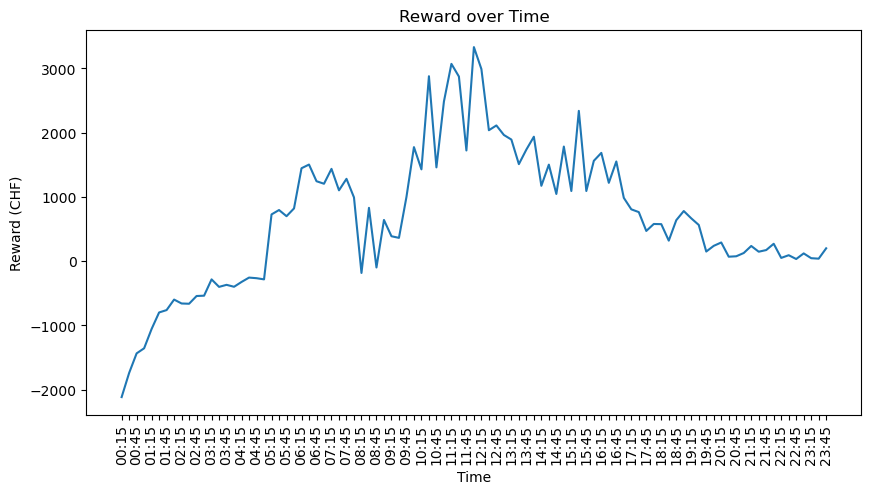

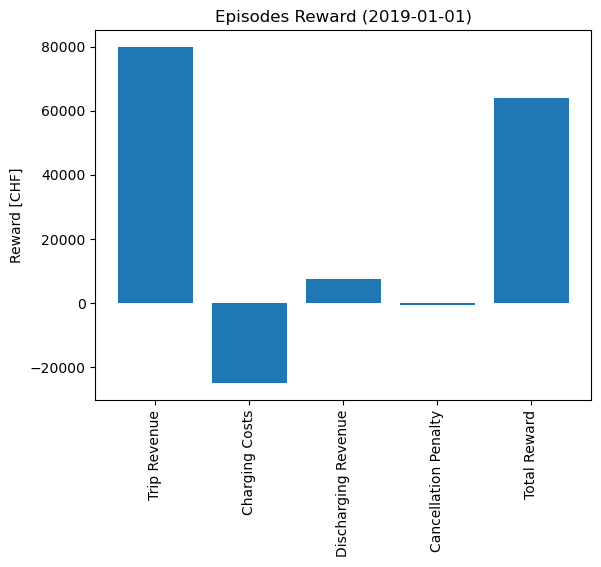

minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 00:15:00 --------
Reward in this step: -2041.1703786677083
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 00:30:00 --------
Reward in this step: -1902.694722048298
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 00:45:00 --------
Reward in this step: -1562.9114544007703
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 01:00:00 --------
Reward in this step: -1482.5949817460603
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 01:15:00 --------
Reward in this step: -1332.534663130711
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 01:30:00 --------
Reward in this step: -1065.3138003838628
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 01:45:00 --------
Reward in this step: -913.992483803939
minimum SOC
3.851033641599777e-05
-------- State at time 2019-01-02 02:00:00 --------
Reward in this step: -736.050

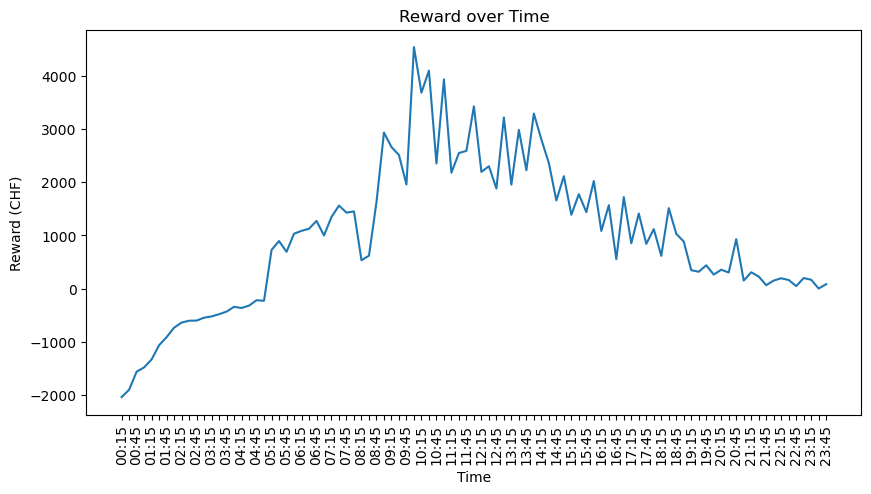

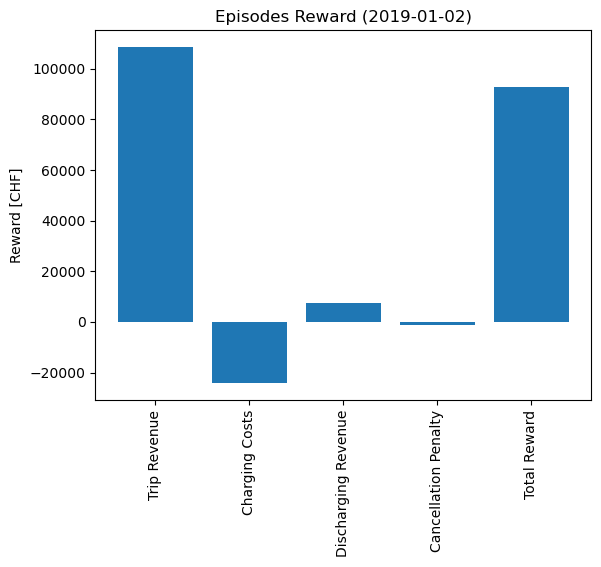

minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 00:15:00 --------
Reward in this step: -1979.3548718645056
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 00:30:00 --------
Reward in this step: -1845.4328668053552
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 00:45:00 --------
Reward in this step: -1545.2579216938248
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 01:00:00 --------
Reward in this step: -1384.155751757895
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 01:15:00 --------
Reward in this step: -1294.6912635979643
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 01:30:00 --------
Reward in this step: -1060.7878900320618
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 01:45:00 --------
Reward in this step: -908.2187710657045
minimum SOC
0.00017232657368959625
-------- State at time 2019-01-03 02:00:00 --------
Reward in this step

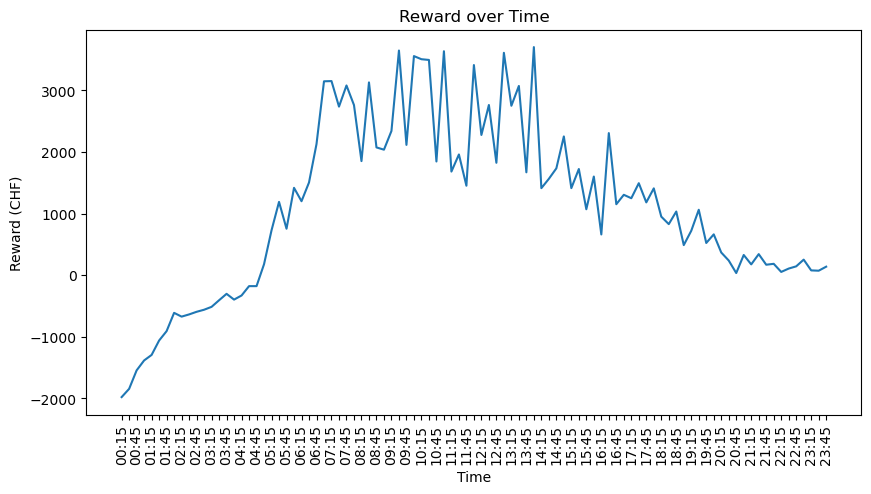

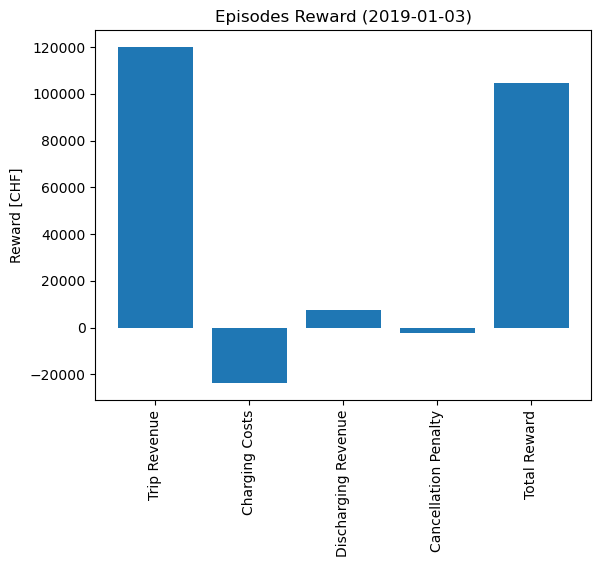

minimum SOC
0.0001404787886818415
-------- State at time 2019-01-04 00:15:00 --------
Reward in this step: -2035.0102492947074
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 00:30:00 --------
Reward in this step: -1772.306960972649
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 00:45:00 --------
Reward in this step: -1398.6794049723335
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 01:00:00 --------
Reward in this step: -1432.4854538354575
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 01:15:00 --------
Reward in this step: -1245.182567463556
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 01:30:00 --------
Reward in this step: -1108.5847119698894
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 01:45:00 --------
Reward in this step: -912.0853132091706
minimum SOC
0.0014749445672779249
-------- State at time 2019-01-04 02:00:00 --------
Reward in this step: -624.36

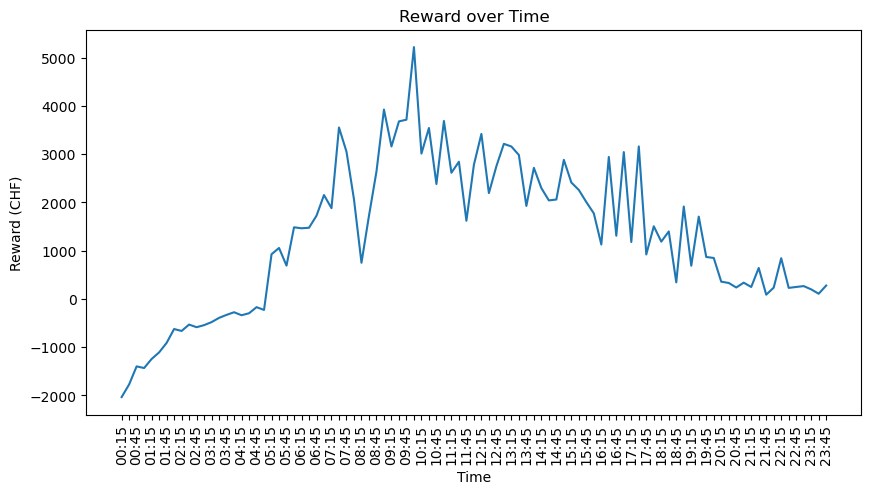

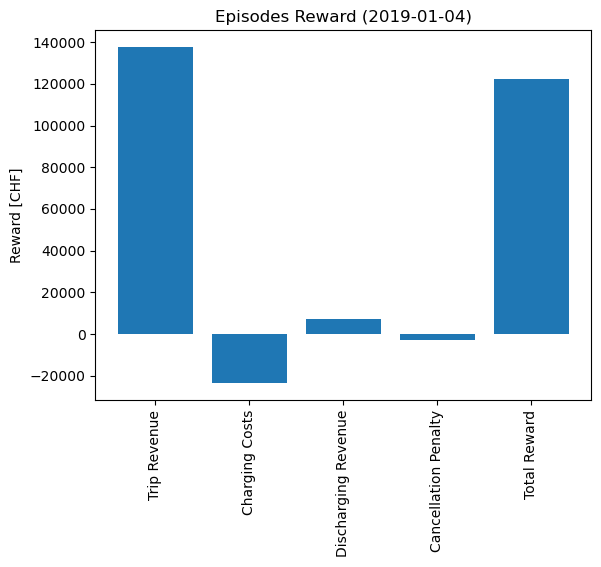

minimum SOC
1.568291248421616e-06
-------- State at time 2019-01-05 00:15:00 --------
Reward in this step: -1790.750565864119
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 00:30:00 --------
Reward in this step: -1640.032870213257
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 00:45:00 --------
Reward in this step: -1407.963870779335
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 01:00:00 --------
Reward in this step: -1054.4079277801586
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 01:15:00 --------
Reward in this step: -1277.8148210898385
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 01:30:00 --------
Reward in this step: -1077.7463443795816
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 01:45:00 --------
Reward in this step: -846.7616024173335
minimum SOC
0.00042645080315451
-------- State at time 2019-01-05 02:00:00 --------
Reward in this step: -642.1917314494603
min

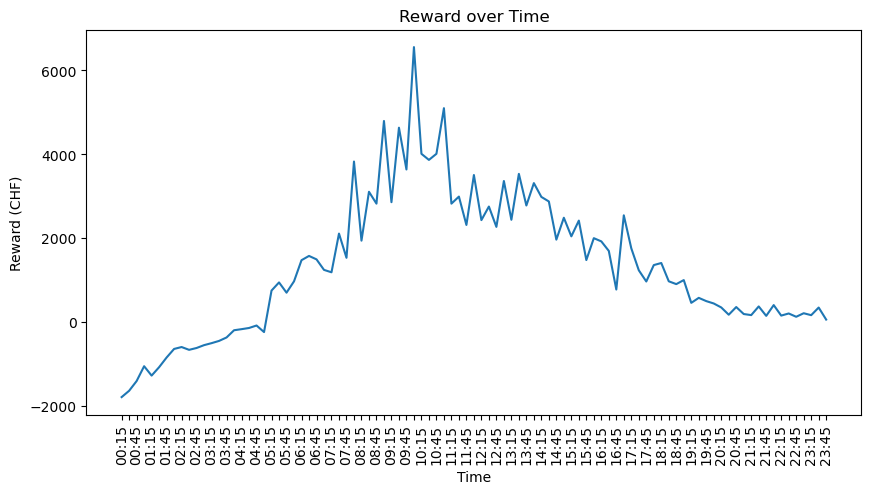

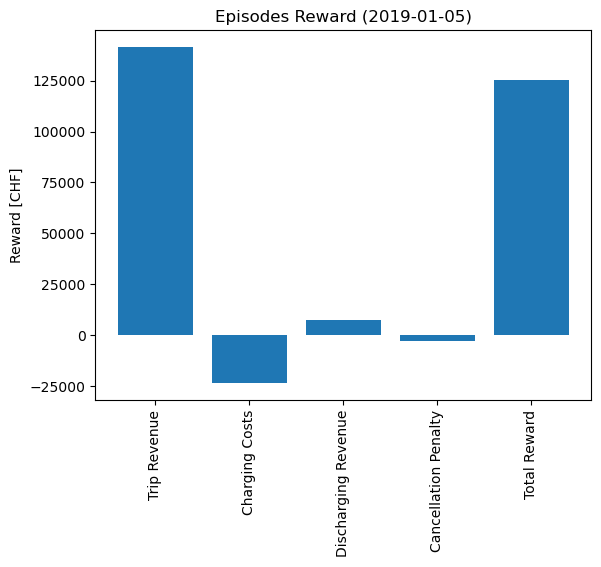

minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 00:15:00 --------
Reward in this step: -1942.2728697642249
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 00:30:00 --------
Reward in this step: -1560.9425382179106
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 00:45:00 --------
Reward in this step: -1442.9391994675152
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 01:00:00 --------
Reward in this step: -1406.6701858088184
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 01:15:00 --------
Reward in this step: -1222.2129849571336
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 01:30:00 --------
Reward in this step: -1056.3759958366782
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 01:45:00 --------
Reward in this step: -924.3393031768446
minimum SOC
5.26107352295524e-05
-------- State at time 2019-01-06 02:00:00 --------
Reward in this step: -549.03018264

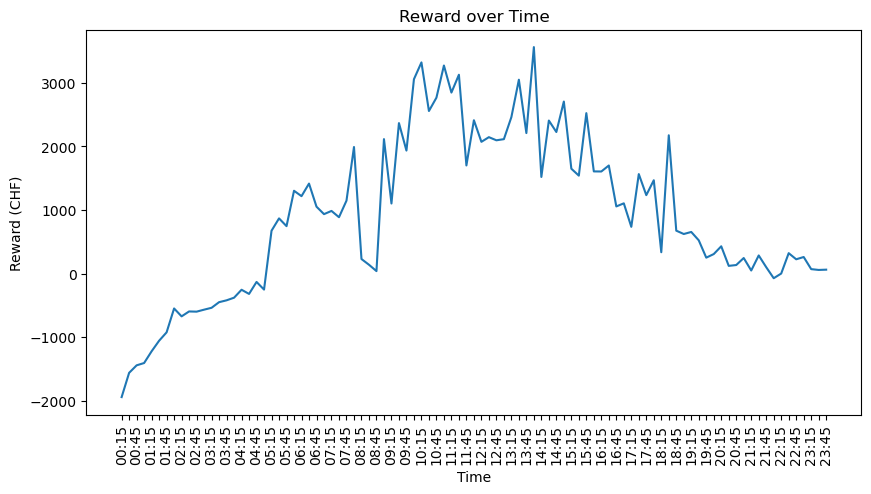

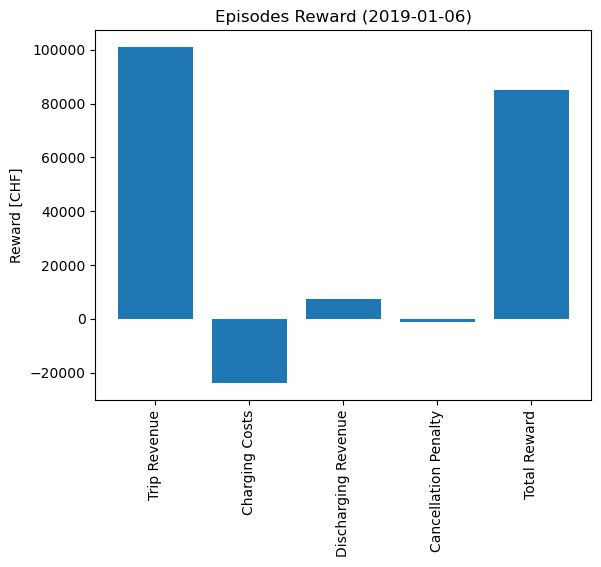

End of Week
minimum SOC
0.000178651502230176
-------- State at time 2019-01-07 00:15:00 --------
Reward in this step: -2064.521206907451
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 00:30:00 --------
Reward in this step: -1799.4130999762403
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 00:45:00 --------
Reward in this step: -1527.9682614829408
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 01:00:00 --------
Reward in this step: -1392.7563857983844
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 01:15:00 --------
Reward in this step: -1199.1798556110543
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 01:30:00 --------
Reward in this step: -1062.4620490500665
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 01:45:00 --------
Reward in this step: -908.3864914506937
minimum SOC
0.00030309467771583165
-------- State at time 2019-01-07 02:00:00 --------
Reward in

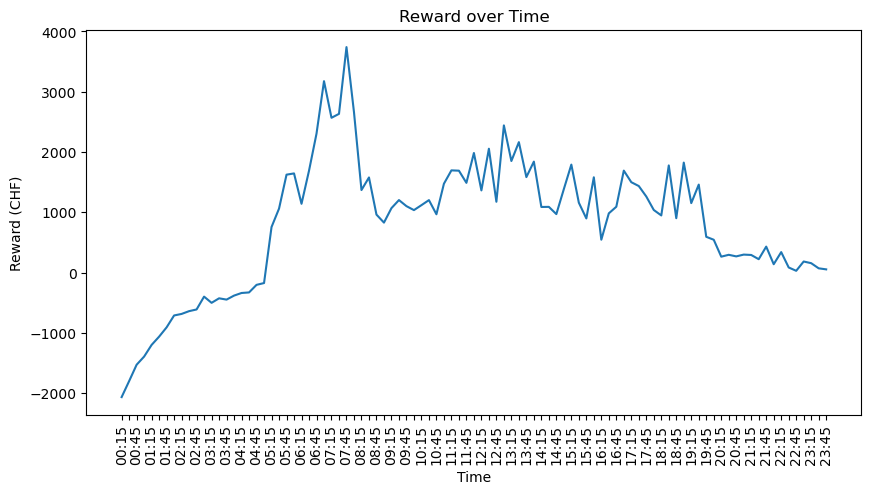

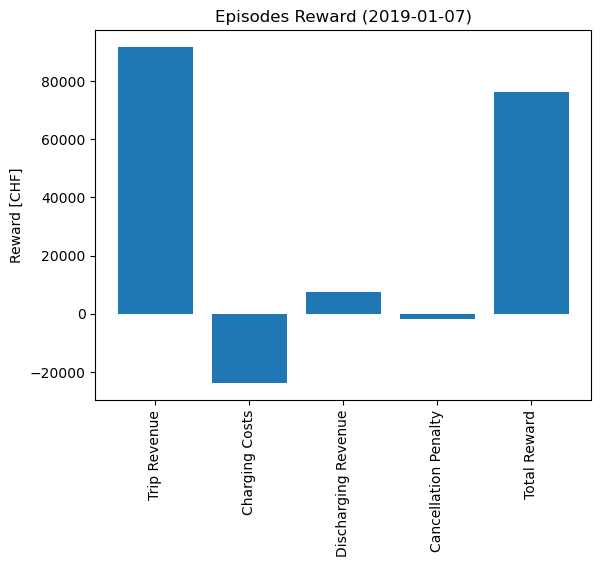

minimum SOC
6.080097227756376e-05
-------- State at time 2019-01-08 00:15:00 --------
Reward in this step: -1985.946595439831
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 00:30:00 --------
Reward in this step: -1822.882434351636
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 00:45:00 --------
Reward in this step: -1621.2210464990194
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 01:00:00 --------
Reward in this step: -1466.2760087285985
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 01:15:00 --------
Reward in this step: -1293.710133065332
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 01:30:00 --------
Reward in this step: -1089.9388793790024
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 01:45:00 --------
Reward in this step: -890.059420375344
minimum SOC
0.000517834425848851
-------- State at time 2019-01-08 02:00:00 --------
Reward in this step: -588.40988582191

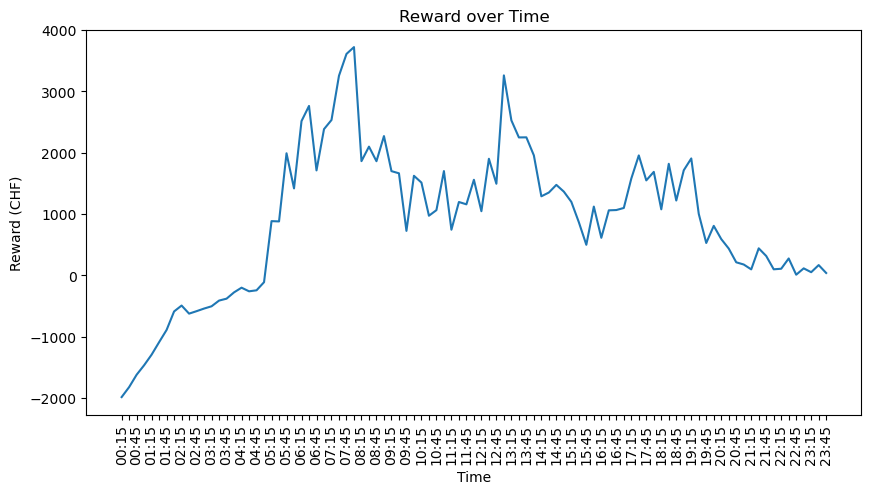

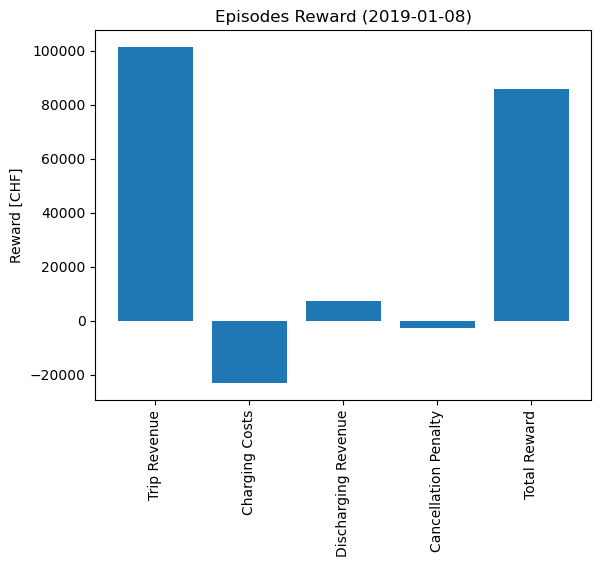

In [35]:
# number of days to simulate 
nr_iterations = 8

env = CarsharingEnv(stations, vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0


# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    assert data["vehicle_no"].tolist() == vehicles["vehicle_no"].tolist(), "Vehicle information is wrong."
    
    # iteration for each day
    for day in range(98,676,96):
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date = pd.to_datetime(data.columns[day-97])
       
        # load reservations of current day, create indices
        sql = "SELECT * FROM msc_2023_dominik.reservations_no_service_discrete WHERE reservationfrom_discrete_date = '{}' or drive_firststart_discrete_date = '{}' ORDER BY reservationfrom_discrete".format(date, date)
        reservations = pd.read_sql(sql, engine)
        reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)

        # get discete data of day
        daily_data = data.iloc[:,day-97:day]   
        
        # reset day at begining of new episode (day)
        s = env.reset(daily_data, reservations)
        
        # last day of a week
        if day == 674:
            end_of_week = True
            print("End of Week")
        
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            ### action ###
            if counter < 20:
                act = np.ones(len(vehicles))
            if counter >= 20 and counter <= 32:
                act = np.zeros(len(vehicles))
                act[:1000] = 2
            if counter >= 32 and counter <= 40:
                act = np.ones(len(vehicles))
            if counter >= 40:
                act = np.zeros(len(vehicles))
                
            #act = np.ones(nr_vehicles)# always charge all vehicles
            # act = np.full(nr_vehicles, 2) # always discharge all vehicles
            # act = np.zeros(nr_vehicles) # do nothing
            
            # proceed one time step
            s, rew, daily_data, done, _ = env.step(act, daily_data, reservations, electricity_price)
            
            # get timestep statistics 
            env.render(daily_data)
            print("Reward in this step:", rew)
            counter +=1
        
        # summary statistics of episode (day)
        env.episode_summary_statistics(daily_data)
        count += 1